In [1]:
#各ライブラリのimport
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<p>
<h4>交差検証</h4>
　交差検証とはデータの解析と評価を交差させることで、より正確な推定値を求める手法。
<br>
　ハイパーパラメータの調整には検証データを用いる。そのため、1つの検証データだけでは、最適な値か判断できない場合がある。そのため、交差検証を用いて一番評価の良いハイパーパラメータに調整する。
<h4>K-Fold</h4>
　K分割交差検証（以下K-Fold）は最も一般的な交差検証である。データをK個に分割し、K-1個を訓練データ、1個をテストデータとし、データを交差させながらK回行い、得られた結果の平均値を求める。
<br>
　交差検証は、split()メソッドをfor文で扱うことで実装できる。
<h4>ベイズ最適化</h4>
　ブラックボックス関数(入力に対して出力の関数値の情報のみが得られる関数)に対して、限られた観測データから関数の形を推定する方法。
<br>
　ベイズ最適化では、次に評価すべき候補点を選択するための関数である獲得関数を最大化する点xを指定し、その点xでのブラックボックス関数の出力yを観測する。それによって得られた新しいデータを加えて、再び獲得関数を最大化する点xを指定する。このような手順を繰り返すことで、最適な解を探索する。
<br>
　ベイズ最適化では、ブラックボックス関数がガウス過程に従うことを仮定している。
<h4>ベイズ最適化のメリット</h4>
・連続的でない関数に適用できる<br>
・最適解を比較的低コスト、短時間で見つけられる<br>
・一貫した手法で最適化できる<br>
</p>

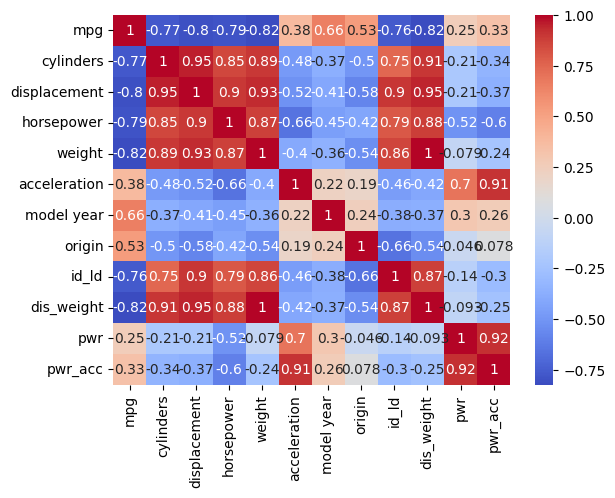

In [31]:
df_train = pd.read_csv('データ/train.tsv' , sep = '\t')
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_train_test = pd.concat([df_train , df_test] , axis =0)
df_train_test['horsepower'] = df_train_test['horsepower'].replace({'?':np.nan}).astype(float)
#df_train['model year'] = df_train['model year'].replace({73:1,70:2,72:3,75:4,76:5,71:6,77:7,78:8,79:9,74:10,82:11,81:12,80:13})
df_train['model year'] = df_train['model year'].replace({73:70,70:71,72:72,75:73,76:74,71:75,77:76,78:77,79:78,74:79,82:80,81:81,80:82})
#シリンダー(気筒数)で割ることで相関を下げる
df_train['id_ld'] = df_train['displacement']/df_train['cylinders']
#dis_weight
df_train['dis_weight'] = df_train['displacement'] + df_train['weight']

df_train.iloc[24 , 4] = df_train_test[df_train_test['displacement'] == 151]['horsepower'].mean()
#renault 18
df_train.iloc[113 , 4] = df_train_test[(98 <= df_train_test['displacement']) & (df_train_test['displacement']<= 102)]['horsepower'].mean()
#renault lecar deluxe
df_train.iloc[145 , 4] = df_train_test[df_train_test['displacement'] == 85]['horsepower'].mean()
#ford pintot
df_train.iloc[175 , 4] = df_train_test[df_train_test['car name'] == 'ford pinto']['horsepower'].mean()
#pwr
df_train['pwr'] = df_train['weight'].astype(float)/df_train['horsepower'].astype(float)
#pwr_acc
df_train['pwr_acc'] = df_train['pwr'] + df_train['acceleration']
df_train_drop = df_train.drop([ 'id' , 'car name' ,] , axis = 1)
#相関係数のヒートマップ
sns.heatmap(df_train_drop.corr() , cmap='coolwarm' , annot=True)
plt.show()
#year降りなおした方が相関係数は上がる
#多重共線性はr>0.95

In [52]:
df_train_test['model year'].unique()

array([80, 78, 74, 79, 81, 73, 70, 71, 77, 75, 72, 82, 76], dtype=int64)

In [2]:
#チューニングなしver
#データ読み込み
df_train = pd.read_csv('データ/train.tsv' , sep = '\t')
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_train_test = pd.concat([df_train , df_test] , axis =0)
#print(df_train_test[df_train_test['horsepower'] == "?"])
df_train_test['horsepower'] = df_train_test['horsepower'].replace({'?':np.nan}).astype(float)
df_train[df_train['horsepower'].isnull()]#欠損値を含むカラムの抽出
#欠損値補完
#amc concord dl
df_train_test.iloc[24 , 4] = df_train_test[df_train_test['displacement'] == 151]['horsepower'].mean()
#renault 18
df_train_test.iloc[113 , 4] = df_train_test[(98 <= df_train_test['displacement']) & (df_train_test['displacement']<= 102)]['horsepower'].mean()
#renault lecar deluxe
df_train_test.iloc[145 , 4] = df_train_test[df_train_test['displacement'] == 85]['horsepower'].mean()
#ford pinto
df_train_test.iloc[175 , 4] = df_train_test[df_train_test['car name'] == 'ford pinto']['horsepower'].mean()
#ford maverick
df_train_test.loc[70 , 'horsepower'] = df_train_test[df_train_test['car name'] == "ford maverick"]['horsepower'].mean()
#ford mustang cobra
df_train_test.loc[112 , 'horsepower'] = df_train_test[df_train_test['displacement'] == 140]['horsepower'].mean()

#pwrカラムの作成
#df_train_test['pwr'] = df_train_test['weight']/df_train_test['horsepower']

#id_ldカラム作成
#df_train['id_ld'] = df_train['displacement']/ df_train['cylinders']

#dis_weightカラムの作成
df_train_test['dis_weight'] = df_train_test['displacement'] + df_train_test['weight']

#年代の番号降り直し
#df_train_test['model year'] = df_train_test['model year'].replace({73:1,70:2,72:3,75:4,76:5,71:6,77:7,78:8,79:9,74:10,82:11,81:12,80:13})
#年代降り直し(70~82)
#df_train_test['model year'] = df_train_test['model year'].replace({73:70,70:71,72:72,75:73,76:74,71:75,77:76,78:77,79:78,74:79,82:80,81:81,80:82})
#df_train_test['model_year_']=df_train_test['model year']
#print(df_train_test['model year'].head())

#ラベルエンコーディング(train,test結合版)
#メーカーカラム作成
df_split = df_train_test['car name'].str.split(expand = True)#str.split('')で文字列を''で分割(入力しないと空白で分割される)
df_train_test['manufacturers name'] = df_split.iloc[:, 0]
df_train_test['manufacturers name'] = df_train_test['manufacturers name'].replace({"toyouta":"toyota", "vw":"volkswagen", "vokswagen":"volkswagen",  "chevroelt":"chevrolet" ,  "chevy":"chevrolet","mercury":"ford", "datsun":"nissan", "maxda":"mazda",  "mercedes":"mercedes-benz"})#カラム名の修正
#国とメーカーカラムの結合
df_train_test['manufacturers_country'] = df_train_test['manufacturers name'] + df_train_test['origin'].astype(str) 
#メーカーとmodel yearの結合
#df_train_test['manufacturers_year'] = df_train_test['manufacturers name'] + df_train_test['model year'].astype(str)
#国とmodel yearの結合
#df_train_test['origin_year'] =df_train_test['origin'].astype(str) + _ + df_train_test['model year'].astype(str)
#3つとも結合
#df_train_test['manufacturers_country_year'] = df_train_test['manufacturers name'] + df_train_test['origin'].astype(str) + df_train_test['model year'].astype(str)
#エンコーディング
df_number = pd.get_dummies(df_train_test , columns = [  'manufacturers_country',
                                                        #'manufacturers_country_year'
                                                        #'manufacturers name' ,
                                                        #'model year' ,
                                                        #'manufacturers_year',
                                                        #'origin'
                                                      ] , dtype = int)

df_train = df_number.iloc[:199 , :]
df_test = df_number.iloc[199: , :]

#学習
#目的変数の分離
X = df_train.drop([ 'id' , 'car name' , 'mpg' , 
                   'cylinders',
                   'weight',
                    'manufacturers name' , 
                    #'model year' , 
                    #'origin',
                    'displacement'
                    ] , axis = 1)
y = df_train['mpg']
features_test = df_test.drop([ 'id' , 'car name' , 'mpg' , 
                              'cylinders',
                              'weight',
                               'manufacturers name' , 
                               #'model year' , 
                               #'origin',
                               'displacement'
                              ] , axis = 1)
#交差検証の評価指標をRSMEに指定
scoring = 'neg_mean_squared_error'
#import
import xgboost as xgb
from xgboost import XGBRegressor
# モデル作成
model = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                     random_state=42, n_estimators=10000)  # チューニング前のモデル
# 学習時fitパラメータ指定
fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'early_stopping_rounds': 10,  # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              'eval_set': [(X, y)]  # early_stopping_roundsの評価指標算出用データ
              }
#early_stopping_roundsは学習回数を適切なタイミングで打ち止めるための仕組み
#K-分割交差検証
#交差検証は比較的少ないデータセットを使って学習する場合に、過学習を防ぐ（汎化性能を上げる）ためにする
from sklearn.model_selection import KFold
cv = KFold(n_splits=3, shuffle=True, random_state=42)
X

,horsepower,acceleration,model year,origin,dis_weight,manufacturers_country_amc1,manufacturers_country_audi2,manufacturers_country_bmw2,manufacturers_country_buick1,manufacturers_country_cadillac1,...,manufacturers_country_peugeot2,manufacturers_country_plymouth1,manufacturers_country_pontiac1,manufacturers_country_renault2,manufacturers_country_saab2,manufacturers_country_subaru3,manufacturers_country_toyota3,manufacturers_country_triumph2,manufacturers_country_volkswagen2,manufacturers_country_volvo2
0,84.0,16.0,82,1,2660.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,71.0,14.0,79,2,2014.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,108.0,15.5,76,3,3086.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,75.0,14.5,74,1,2215.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,62.0,17.3,81,3,2139.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,65.0,19.2,80,3,2195.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195,139.0,12.8,78,1,3872.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,150.0,12.0,70,1,3737.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,48.0,23.7,80,2,2425.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [29]:
model.fit(X , y , **fit_params )
df_pred = pd.DataFrame(model.predict(features_test))
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_pred = pd.merge(df_test['id'].astype(int) , df_pred , how = 'outer' , right_index = True , left_index=True)
df_pred
#評価
df_pred.to_csv('XGB_proto_sample_submit.csv' , header = False , index = False)

c:\Users\shouh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\shouh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [4]:
#検証曲線実装
#データ読み込み
df_train = pd.read_csv('データ/train.tsv' , sep = '\t')
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_train_test = pd.concat([df_train , df_test] , axis =0)
#print(df_train_test[df_train_test['horsepower'] == "?"])
df_train_test['horsepower'] = df_train_test['horsepower'].replace({'?':np.nan}).astype(float)
df_train[df_train['horsepower'].isnull()]#欠損値を含むカラムの抽出
#欠損値補完
#amc concord dl
df_train_test.iloc[24 , 4] = df_train_test[df_train_test['displacement'] == 151]['horsepower'].mean()
#renault 18
df_train_test.iloc[113 , 4] = df_train_test[(98 <= df_train_test['displacement']) & (df_train_test['displacement']<= 102)]['horsepower'].mean()
#renault lecar deluxe
df_train_test.iloc[145 , 4] = df_train_test[df_train_test['displacement'] == 85]['horsepower'].mean()
#ford pinto
df_train_test.iloc[175 , 4] = df_train_test[df_train_test['car name'] == 'ford pinto']['horsepower'].mean()
#ford maverick
df_train_test.loc[70 , 'horsepower'] = df_train_test[df_train_test['car name'] == "ford maverick"]['horsepower'].mean()
#ford mustang cobra
df_train_test.loc[112 , 'horsepower'] = df_train_test[df_train_test['displacement'] == 140]['horsepower'].mean()
#pwrカラム作成in_test['displacement']
df_train_test['pwr'] = df_train_test['weight']/df_train_test['horsepower']
#ラベルエンコーディング(train,test結合版)
#メーカーカラム作成
df_split = df_train_test['car name'].str.split(expand = True)#str.split('')で文字列を''で分割(入力しないと空白で分割される)
df_train_test['manufacturers name'] = df_split.iloc[:, 0]
df_train_test['manufacturers name'] = df_train_test['manufacturers name'].replace({"toyouta":"toyota", "vw":"volkswagen", "vokswagen":"volkswagen",  "chevroelt":"chevrolet" ,  "chevy":"chevrolet","mercury":"ford", "datsun":"nissan", "maxda":"mazda",  "mercedes":"mercedes-benz"})#カラム名の修正
#国とメーカーカラムの結合
df_train_test['manufacturers_country'] = df_train_test['manufacturers name'] + df_train_test['origin'].astype(str)
#エンコーディング
df_number = pd.get_dummies(df_train_test , columns = ['manufacturers_country'] , dtype = int)
df_train = df_number.iloc[:199 , :]
df_test = df_number.iloc[199: , :]

#学習
#目的変数の分離
X = df_train.drop([ 'id' , 'car name' , 'mpg' , 'cylinders','manufacturers name'] , axis = 1)
y = df_train['mpg']
features_test = df_test.drop([ 'id' , 'car name' , 'mpg' , 'cylinders','manufacturers name'] , axis = 1)
#交差検証の評価指標をRSMEに指定
scoring = 'neg_mean_squared_error'
#import
import xgboost as xgb
from xgboost import XGBRegressor
# モデル作成
model = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                     random_state=42, n_estimators=10000)  # チューニング前のモデル
# 学習時fitパラメータ指定
fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'early_stopping_rounds': 10,  # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              'eval_set': [(X, y)]  # early_stopping_roundsの評価指標算出用データ
              }
#early_stopping_roundsは学習回数を適切なタイミングで打ち止めるための仕組み
#K-分割交差検証
#交差検証は比較的少ないデータセットを使って学習する場合に、過学習を防ぐ（汎化性能を上げる）ためにする
from sklearn.model_selection import KFold
cv = KFold(n_splits=3, shuffle=True, random_state=42)

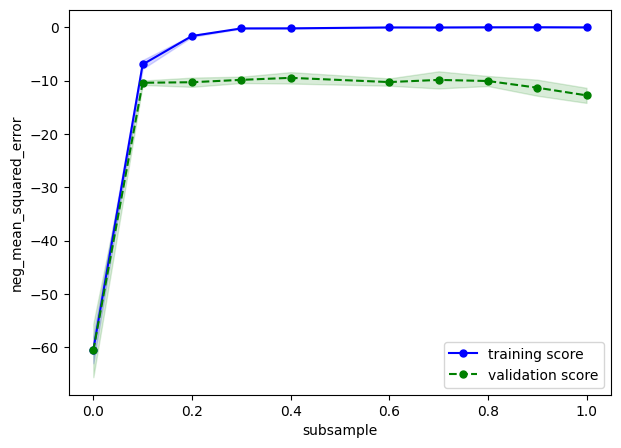

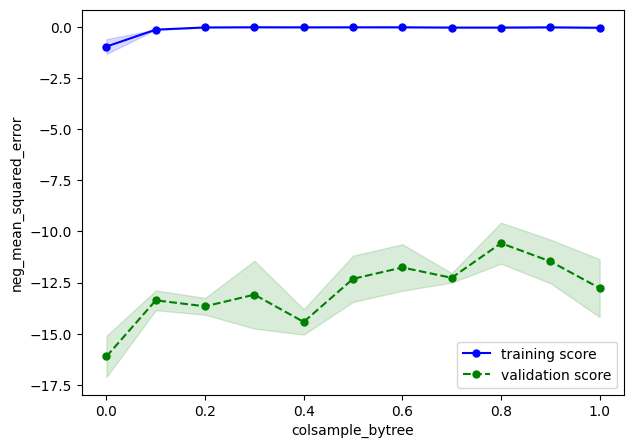

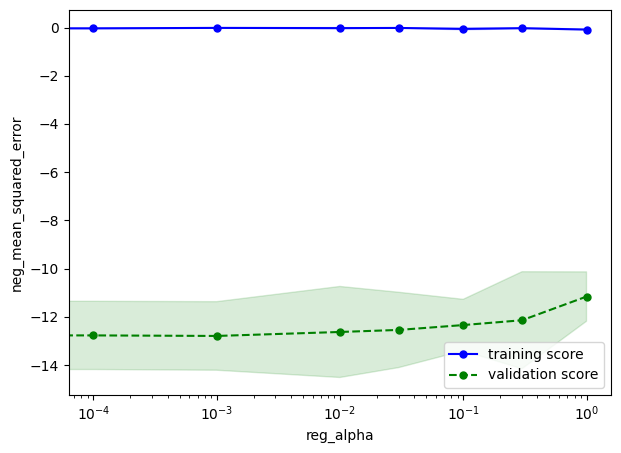

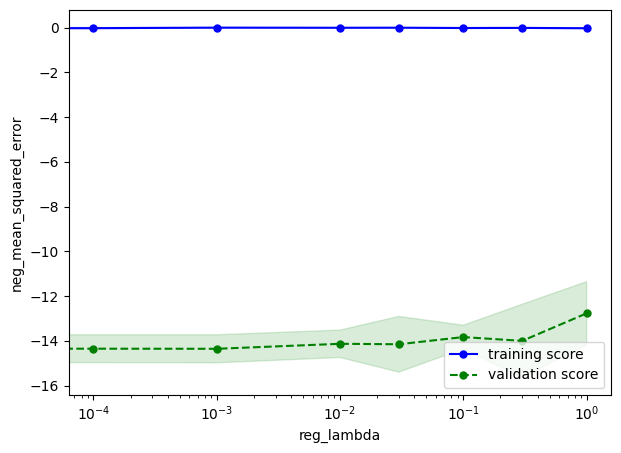

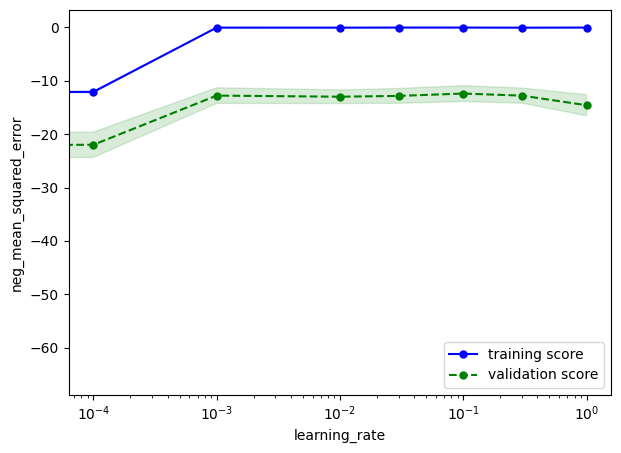

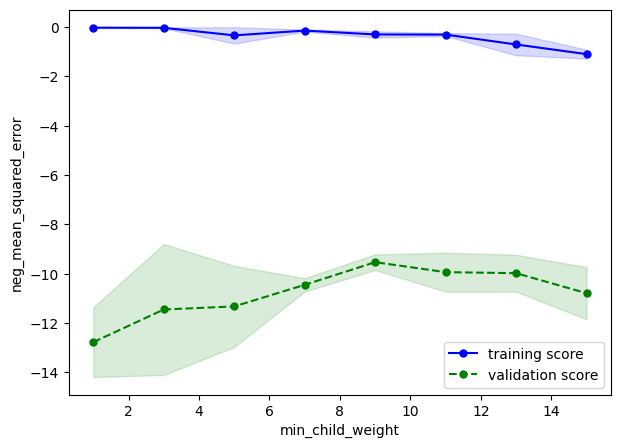

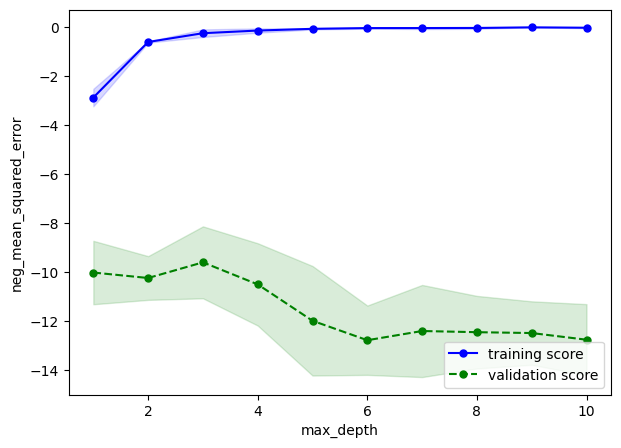

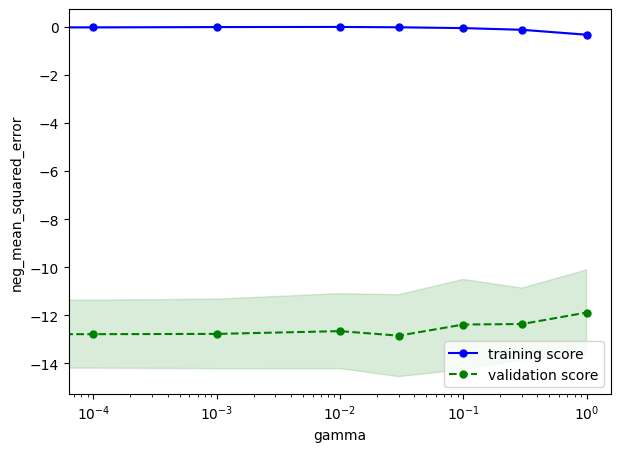

In [4]:
#検証曲線
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
#辞書オブジェクト = {'key' : 要素}
#オブジェクト.items(): 各要素のキーと値に対してforループ処理
cv_params = {'subsample': [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bytree': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'reg_alpha': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'reg_lambda': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'learning_rate': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'min_child_weight': [1, 3, 5, 7, 9, 11, 13, 15],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             'gamma': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0]
             }
param_scales = {'subsample': 'linear',
                'colsample_bytree': 'linear',
                'reg_alpha': 'log',
                'reg_lambda': 'log',
                'learning_rate': 'log',
                'min_child_weight': 'linear',
                'max_depth': 'linear',
                'gamma': 'log'
                }
#for文の基本構造
#for 変数名(任意) in イテラブルオブジェクト:
    #処理

#enumerate()；forループでindexを取得する関数,デフォルトだと0から
#複数のイテラブルオブジェクト（リストなど）の要素を複数の変数として取得するにはzip()を使う
#names = ['Alice', 'Bob', 'Charlie']
#ages = [24, 50, 18]
#for name, age in zip(names, ages):
    #print(name, age)
# Alice 24
# Bob 50
# Charlie 18

#複数のイテラブルオブジェクト（リストなど）の要素とインデックス（カウンタ）を同時に取得するにはenumerate()とzip()を組み合わせて使う。
#(k,v)はインデックスをつける任意のオブジェクト
#k,vという変数にcv_paramsのkeyと要素の値をそれぞれ格納していくイメージ
#

for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X, y=y,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)#n_jobs: 同時実行数(-1: コア数で並列実行)
   # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.rcParams["figure.figsize"] = [7 , 5]#グラフのサイズ指定(これより下のグラフすべてに適用される、グローバルなイメージ)
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例

    # グラフを描画
    plt.show()    


In [3]:
#optunaによるベイズ最適化
#べsとスコア時の範囲
#('learning_rate',0.001,0.3,log=True)
#('min_child_weight',7,13)
#('max_depth',1,4),'
#('colsample_bytree', 0.2, 1.0
#('subsample', 0.1, 1.0)
#t('reg_alpha', 0.001, 0.1, =True),'
#('reg_lambda',0.001, 1, log=True), 
#('gamma', 0.01, 0.1, log=True),
#n_traial = 1000
import optuna
from sklearn.model_selection import cross_val_score
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    #objective内で、値を探索したいところに、trial.suggest_xxxと記述
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 7, 13),
        'max_depth': trial.suggest_int('max_depth', 1, 4),#1~4の整数内(_int)で探索
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),#0.2~1.0の浮動小数内(_float)で探索
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.01, 0.1, log=True),
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, X, y, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
#optuna.create_studyでタスク(study)を作成
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=42))
#study.optimizeでbayes_objectiveを引数として、n_trialsで試行回数を設定すると最適化が始まる
study.optimize(bayes_objective, n_trials=1000)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
model.set_params(**best_params)#best_paramsをパラメータとして適用
model.fit(X , y , **fit_params )
df_pred = pd.DataFrame(model.predict(features_test))
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_pred = pd.merge(df_test['id'].astype(int) , df_pred , how = 'outer' , right_index = True , left_index=True)
df_pred
#評価
df_pred.to_csv('XGB_BY_sample_submit.csv' , header = False , index = False)

c:\Users\shouh\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-03-12 21:39:22,780] A new study created in memory with name: no-name-6b1c00df-5211-4475-9fe0-a33ba22b8fac
[I 2024-03-12 21:39:25,282] Trial 0 finished with value: -9.19708499937345 and parameters: {'learning_rate': 0.023688639503640783, 'min_child_weight': 13, 'max_depth': 3, 'colsample_bytree': 0.6387926357773329, 'subsample': 0.24041677639819287, 'reg_alpha': 0.01432169828911152, 'reg_lambda': 0.0014936568554617625, 'gamma': 0.07348118405270448}. Best is trial 0 with value: -9.19708499937345.
[I 2024-03-12 21:39:26,952] Trial 1 finished with value: -8.562385721188148 and parameters: {'learning_rate': 0.039913058785616795, 'min_child_weight': 11, 'max_depth': 1, 'colsample_bytree': 0.9729188669457949, 's

C:\Users\shouh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\shouh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\shouh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38263 (\N{CJK UNIFIED IDEOGRAPH-9577}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\shouh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\shouh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37325 (\N{C

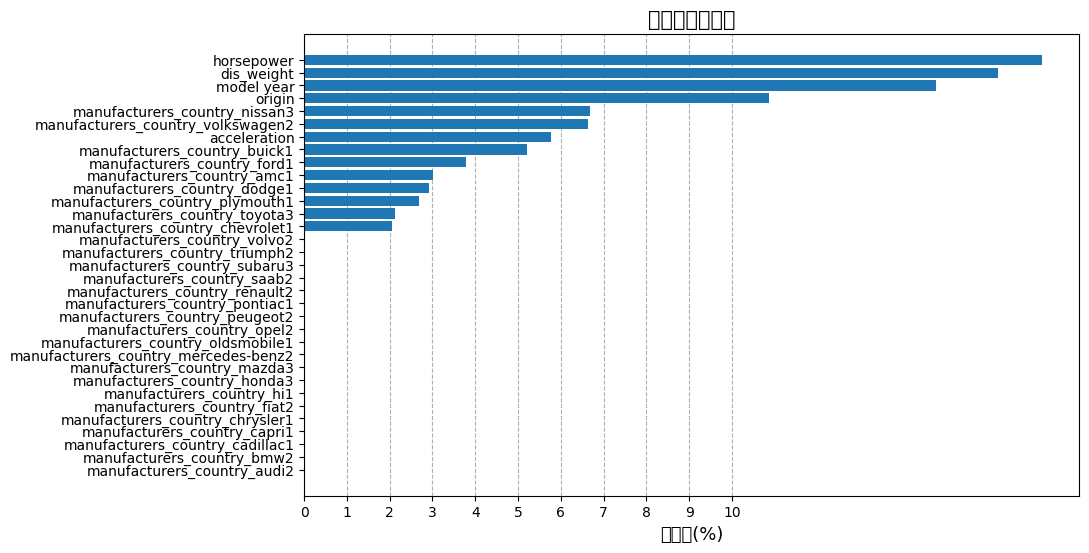

In [4]:
#特徴量重要度
feature_importances = model.feature_importances_ * 100

# 特徴の数
num_features = len(feature_importances)

# カラム名と重要度を対応させる
feature_importance_dict = dict(zip(X.columns, feature_importances))

# 重要度の高い順にソート
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)

# 可視化
plt.rcParams["axes.axisbelow"] = True
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importance)), [item[1] for item in sorted_feature_importance], align='center')
plt.xticks(np.arange(0,11,1))
plt.yticks(range(len(sorted_feature_importance)), [item[0] for item in sorted_feature_importance], rotation=0)
plt.xlabel('重要度(%)', fontsize=13)
plt.title('各特長の重要度', fontsize=15)
plt.grid(axis="x", linestyle="--")
plt.show()

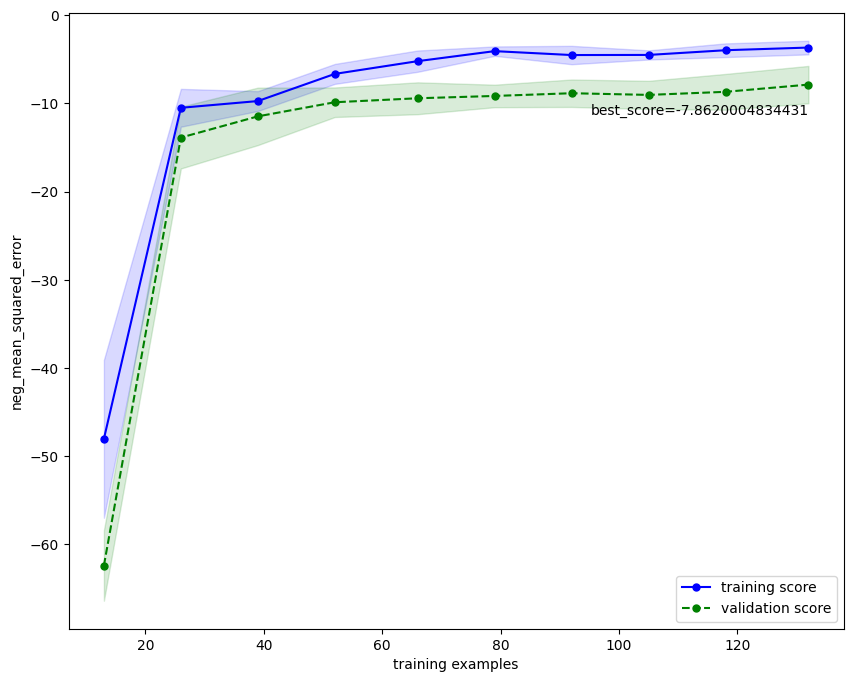

In [15]:
#学習曲線のプロット
#最終的に検証データとtrainデータのスコアが収束していればok
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# 最適パラメータを学習器にセット
model.set_params(**best_params)

# 学習曲線の取得
train_sizes, train_scores, valid_scores = learning_curve(estimator=model,
                                                         X=X, y=y,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         fit_params=fit_params,
                                                         cv=cv, scoring=scoring, n_jobs=-1)
# 学習データ指標の平均±標準偏差を計算
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
train_center = train_mean
train_high = train_mean + train_std
train_low = train_mean - train_std
# 検証データ指標の平均±標準偏差を計算
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)
valid_center = valid_mean
valid_high = valid_mean + valid_std
valid_low = valid_mean - valid_std
# training_scoresをプロット
plt.plot(train_sizes, train_center, color='blue', marker='o', markersize=5, label='training score')
plt.fill_between(train_sizes, train_high, train_low, alpha=0.15, color='blue')
# validation_scoresをプロット
plt.plot(train_sizes, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
plt.fill_between(train_sizes, valid_high, valid_low, alpha=0.15, color='green')
# 最高スコアの表示
best_score = valid_center[len(valid_center) - 1]
plt.text(np.amax(train_sizes), valid_low[len(valid_low) - 1], f'best_score={best_score}',
                color='black', verticalalignment='top', horizontalalignment='right')
# 軸ラベルおよび凡例の指定
plt.xlabel('training examples')  # 学習サンプル数を横軸ラベルに
plt.ylabel(scoring)  # スコア名を縦軸ラベルに
plt.legend(loc='lower right')  # 凡例

In [36]:
#GridSearch
# 最終的なパラメータ範囲(変数除去)
#検証曲線から考えられる適切なパラメータの範囲
#過学習(検証データと学習データのスコアが離れてる傾向)、未学習(両データのスコアが下降している)の範囲は避ける
#reg_alpha :[ 0.01,0.03,0.1,0.2,1]
#colsample_bytree ; 0.3 , 0.4,0.5,0.6
#gamma ; 0,01,0.03,0.1,0.3,1
#reg_lamba;0.1,0.3,1
#'max_depth': [2, 3, 4]
            #ベストスコアの範囲
            #'learning_rate': [0.001, 0.01, 0.1, 0.2],#学習率(0～1)
            # 'min_child_weight': [5, 7, 9, 11],#決定木の葉の重みの下限
             #'max_depth': [2 ,3 ,4],
             #'colsample_bytree': [0.2, 0.5, 0.8,1.0],#説明変数のサンプル抽出比(木)(0~1)
            # 'subsample': [0.1, 0.2, 0.3, 0.4],#各決定木のサンプル抽出比(0~1)、小さいほど保守的になる
            # 'reg_alpha' :[ 0.01,0.03,0.1,0.2,1]
#best_params
#'colsample_bytree': 0.5,
#'learning_rate': 0.1,
# 'max_depth': 2,
# 'min_child_weight': 5,
# 'reg_alpha': 0.2,
# 'subsample': 0.4}
             

cv_params = {'learning_rate': [0.01, 0.03, 0.1, 0.3],#学習率(0～1)
             'min_child_weight': [5, 7, 9, 11],#決定木の葉の重みの下限
             'max_depth': [1, 2 ,3 ,4],
             'colsample_bytree': [0.2, 0.5, 0.8,1.0],#説明変数のサンプル抽出比(木)(0~1)
             'subsample': [0.2, 0.5, 0.8, 1.0],#各決定木のサンプル抽出比(0~1)、小さいほど保守的になる
                #'reg_alpha': [0.2],
                #'gamma' : [0.01,0.03,0.1,0.3,1],
                #'reg_lambda':[0.03,0.1,0.3,1]
             }
# グリッドサーチのインスタンス作成
#引数一覧
#estimator: チューニングを行うモデル
#param_grid: パラメータ候補パラメータ名: [候補リスト]
#scoring: 評価指標(今回はneg_mean_squared_error(RSME))
#cv: Cross Validationの分割数(default: 3)
#verbose: ログ出力レベル
#n_jobs: 同時実行数(-1: コア数で並列実行)
#refit: 　trueのとき最良のパラメータで再学習
from sklearn.model_selection import GridSearchCV
grid_model = GridSearchCV(model, cv_params,cv = cv,
                      scoring='neg_mean_squared_error', n_jobs=-1)
grid_model.fit(X , y , **fit_params )
best = grid_model.best_estimator_

df_pred = pd.DataFrame(best.predict(features_test))
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_pred = pd.merge(df_test['id'].astype(int) , df_pred , how = 'outer' , right_index = True , left_index=True)
df_pred
#評価
df_pred.to_csv('XGB_GS_proto_sample_submit.csv' , header = False , index = False)

c:\Users\shouh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\shouh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [16]:
grid_model.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 5,
 'subsample': 0.5}

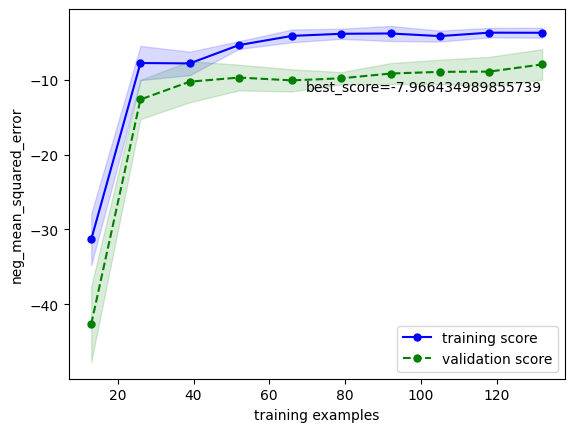

In [15]:
#学習曲線のプロット
#最終的に検証データとtrainデータのスコアが収束していればok
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# 学習曲線の取得
train_sizes, train_scores, valid_scores = learning_curve(estimator=best,
                                                         X=X, y=y,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         fit_params=fit_params,
                                                         cv=cv, scoring=scoring, n_jobs=-1)
# 学習データ指標の平均±標準偏差を計算
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
train_center = train_mean
train_high = train_mean + train_std
train_low = train_mean - train_std
# 検証データ指標の平均±標準偏差を計算
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)
valid_center = valid_mean
valid_high = valid_mean + valid_std
valid_low = valid_mean - valid_std
# training_scoresをプロット
plt.plot(train_sizes, train_center, color='blue', marker='o', markersize=5, label='training score')
plt.fill_between(train_sizes, train_high, train_low, alpha=0.15, color='blue')
# validation_scoresをプロット
plt.plot(train_sizes, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
plt.fill_between(train_sizes, valid_high, valid_low, alpha=0.15, color='green')
# 最高スコアの表示
best_score = valid_center[len(valid_center) - 1]
plt.text(np.amax(train_sizes), valid_low[len(valid_low) - 1], f'best_score={best_score}',
                color='black', verticalalignment='top', horizontalalignment='right')
# 軸ラベルおよび凡例の指定
plt.xlabel('training examples')  # 学習サンプル数を横軸ラベルに
plt.ylabel(scoring)  # スコア名を縦軸ラベルに
plt.legend(loc='lower right')  # 凡例

In [13]:
#モデル実装(train,test結合版)

#gridsearchなし
#データ読み込み
df_train = pd.read_csv('データ/train.tsv' , sep = '\t')
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_train_test = pd.concat([df_train , df_test] , axis =0)
#print(df_train_test[df_train_test['horsepower'] == "?"])
df_train_test['horsepower'] = df_train_test['horsepower'].replace({'?':np.nan}).astype(float)
df_train[df_train['horsepower'].isnull()]#欠損値を含むカラムの抽出
#欠損値補完
#amc concord dl
df_train_test.iloc[24 , 4] = df_train_test[df_train_test['displacement'] == 151]['horsepower'].mean()
#renault 18
df_train_test.iloc[113 , 4] = df_train_test[(98 <= df_train_test['displacement']) & (df_train_test['displacement']<= 102)]['horsepower'].mean()
#renault lecar deluxe
df_train_test.iloc[145 , 4] = df_train_test[df_train_test['displacement'] == 85]['horsepower'].mean()
#ford pinto
df_train_test.iloc[175 , 4] = df_train_test[df_train_test['car name'] == 'ford pinto']['horsepower'].mean()
#ford maverick
df_train_test.loc[70 , 'horsepower'] = df_train_test[df_train_test['car name'] == "ford maverick"]['horsepower'].mean()
#ford mustang cobra
df_train_test.loc[112 , 'horsepower'] = df_train_test[df_train_test['displacement'] == 140]['horsepower'].mean()
#pwrカラム作成
df_train_test['pwr'] = df_train_test['weight']/df_train_test['horsepower']
#ラベルエンコーディング(train,test結合版)
#メーカーカラム作成
df_split = df_train_test['car name'].str.split(expand = True)#str.split('')で文字列を''で分割(入力しないと空白で分割される)
df_train_test['manufacturers name'] = df_split.iloc[:, 0]
df_train_test['manufacturers name'] = df_train_test['manufacturers name'].replace({"toyouta":"toyota", "vw":"volkswagen", "vokswagen":"volkswagen",  "chevroelt":"chevrolet" ,  "chevy":"chevrolet","mercury":"ford", "datsun":"nissan", "maxda":"mazda",  "mercedes":"mercedes-benz"})#カラム名の修正

#エンコーディング
df_number = pd.get_dummies(df_train_test , columns = ['origin' , 'manufacturers name'] , dtype = int)
#print(df_number)
df_train = df_number.iloc[:198 , :]
df_test = df_number.iloc[199: , :]

#目的変数の分離
features_train = df_train.drop(['weight', 'id' , 'car name' , 'mpg','horsepower' , 'cylinders','acceleration'] , axis = 1)
target_train = df_train['mpg']

features_test = df_test.drop(['weight' , 'id' , 'car name' , 'mpg','horsepower' , 'cylinders','acceleration'] , axis = 1)
#学習
from xgboost import XGBRegressor
#early_stopping_roundsは学習回数を適切なタイミングで打ち止めるための仕組み
model = XGBRegressor()
model.fit(features_train , target_train)

df_pred = pd.DataFrame(model.predict(features_test))
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_pred = pd.merge(df_test['id'].astype(int) , df_pred , how = 'outer' , right_index = True , left_index=True)
df_pred
#評価
df_pred.to_csv('XGBsample_submit.csv' , header = False , index = False)

In [30]:
#モデル実装(train,test結合版)#メーカーと国は別
#gridsearch版

#kfoldを入れ、pwrカラムを追加しない時が一番高かった。
#欠損値補完と標準化の間にエンコーディングの操作を入れるとエラーが出てしまったため改善しよう
#データ読み込み
df_train = pd.read_csv('データ/train.tsv' , sep = '\t')
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_train_test = pd.concat([df_train , df_test] , axis =0)
#print(df_train_test[df_train_test['horsepower'] == "?"])
df_train_test['horsepower'] = df_train_test['horsepower'].replace({'?':np.nan}).astype(float)
df_train[df_train['horsepower'].isnull()]#欠損値を含むカラムの抽出
#欠損値補完
#amc concord dl
df_train_test.iloc[24 , 4] = df_train_test[df_train_test['displacement'] == 151]['horsepower'].mean()
#renault 18
df_train_test.iloc[113 , 4] = df_train_test[(98 <= df_train_test['displacement']) & (df_train_test['displacement']<= 102)]['horsepower'].mean()
#renault lecar deluxe
df_train_test.iloc[145 , 4] = df_train_test[df_train_test['displacement'] == 85]['horsepower'].mean()
#ford pinto
df_train_test.iloc[175 , 4] = df_train_test[df_train_test['car name'] == 'ford pinto']['horsepower'].mean()
#ford maverick
df_train_test.loc[70 , 'horsepower'] = df_train_test[df_train_test['car name'] == "ford maverick"]['horsepower'].mean()
#ford mustang cobra
df_train_test.loc[112 , 'horsepower'] = df_train_test[df_train_test['displacement'] == 140]['horsepower'].mean()
#pwrカラム作成
#df_train_test['pwr'] = df_train_test['weight']/df_train_test['horsepower']
#ラベルエンコーディング(train,test結合版)
#メーカーカラム作成
df_split = df_train_test['car name'].str.split(expand = True)#str.split('')で文字列を''で分割(入力しないと空白で分割される)
df_train_test['manufacturers name'] = df_split.iloc[:, 0]
df_train_test['manufacturers name'] = df_train_test['manufacturers name'].replace({"toyouta":"toyota", "vw":"volkswagen", "vokswagen":"volkswagen",  "chevroelt":"chevrolet" ,  "chevy":"chevrolet","mercury":"ford", "datsun":"nissan", "maxda":"mazda",  "mercedes":"mercedes-benz"})#カラム名の修正

#エンコーディング
df_number = pd.get_dummies(df_train_test , columns = ['origin' , 'manufacturers name'] , dtype = int)
df_train = df_number.iloc[:198 , :]
df_test = df_number.iloc[199: , :]

#目的変数の分離
features_train = df_train.drop([ 'id' , 'car name' , 'mpg' , 'cylinders','weight' ] , axis = 1)
target_train = df_train['mpg']
print(target_train.head())
features_test = df_test.drop([  'id' , 'car name' , 'mpg', 'cylinders' , 'weight'] , axis = 1)
#学習
from xgboost import XGBRegressor
#early_stopping_roundsは学習回数を適切なタイミングで打ち止めるための仕組み
model = XGBRegressor()
#K-分割交差検証
#交差検証は比較的少ないデータセットを使って学習する場合に、過学習を防ぐ（汎化性能を上げる）ためにする
from sklearn.model_selection import KFold
cv = KFold(n_splits=3, shuffle=True, random_state=42)
#gridsearch
from sklearn.model_selection import GridSearchCV

# 最終的なパラメータ範囲
cv_params = {'n_estimators': [200,300,400],
             'learning_rate': [0.01, 0.03, 0.1, 0.3],#学習率(0～1)
             'min_child_weight': [2, 4, 6, 8],#決定木の葉の重みの下限
             'max_depth': [1, 2, 3, 4],#決定木の最大深度(整数)
             'colsample_bytree': [0.2, 0.5, 0.8, 1.0],#説明変数のサンプル抽出比(木)(0~1)
             'subsample': [0.2, 0.5, 0.8, 1.0]#各決定木のサンプル抽出比(0~1)、小さいほど保守的になる
             }
# グリッドサーチのインスタンス作成
#引数一覧
#estimator: チューニングを行うモデル
#param_grid: パラメータ候補パラメータ名: [候補リスト]
#scoring: 評価指標(今回はneg_mean_squared_error(RSME))
#cv: Cross Validationの分割数(default: 3)
#verbose: ログ出力レベル
#n_jobs: 同時実行数(-1: コア数で並列実行)
#refit: 　trueのとき最良のパラメータで再学習

 
grid_model = GridSearchCV(model, cv_params,cv = cv,
                      scoring='neg_mean_squared_error', n_jobs=-1)
grid_model.fit(features_train , target_train)
best = grid_model.best_estimator_
print(best)
df_pred = pd.DataFrame(grid_model.predict(features_test))
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_pred = pd.merge(df_test['id'].astype(int) , df_pred , how = 'outer' , right_index = True , left_index=True)
df_pred
#評価
df_pred.to_csv('XGBsample_submit.csv' , header = False , index = False)
#29.31(300)pwrあり
#29.37



0    29.0
1    31.9
2    19.0
3    28.0
4    37.7
Name: mpg, dtype: float64
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
